In [ ]:
#default_exp receptive_fields

# Investigate ResNet receptive fields

In [ ]:
#exporti
from fastai.vision.all import *
import imageio

## Prepare the network

We load a standard ResNet18 and drop the clasiffication head.

In [ ]:
model = nn.Sequential(*list(resnet18().children())[:-2]) # drop the pooling and linear layers
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

We then convert the network to a linear model to make the receptive field calculations easier. This will shows us the biggest possible receptive field for a neuron. In a fully trained network most of neurons will focus on smaller areas as determined by their weights.

We set all the weights to a small positive number, clear out all the biases and pacify the batchnorm layers. This means every positive value in the input tensor will be linearly multiplied and added up in each layer and will turn up in the output feature map.

In [ ]:
# based on: https://learnopencv.com/cnn-receptive-field-computation-using-backprop/
for module in model.modules():
    # skip errors on container modules, like nn.Sequential
    try:
        # Make all convolution weights equal.
        # Set all biases to zero.
        nn.init.constant_(module.weight, 0.05)
        nn.init.zeros_(module.bias)

        # Set BatchNorm means to zeros, 
        # variances - to 1.
        nn.init.zeros_(module.running_mean)
        nn.init.ones_(module.running_var)
    except:
        pass
    
    # Freeze the BatchNorm stats. 
    if isinstance(module, torch.nn.modules.BatchNorm2d):
        module.eval()

A helper function for rendering:

In [ ]:
def torch2img(x, vmin=0, vmax=None, color=(255,255,255), size=(224*2,224*2)):
    """Converts a torch tensor to a PIL image of size `size` while mapping
       values from `vmin` to `vmax` to colors from black to `color` (RGB
       or grayscale)."""
    if vmax is None:
        vmax = x.max()
    vmax = vmax - vmin
    x = (x - vmin) / vmax
    if len(color) > 1:
        x = x[:,:,None]
    x = x * torch.tensor(color)
    return Image.fromarray(x.detach().numpy().astype(np.uint8)).resize(size, Image.NEAREST)

## Calculate the receptive fields

Let's calculate some receptive fields for a few output activations (14x14) of the penultimate convolutional block:

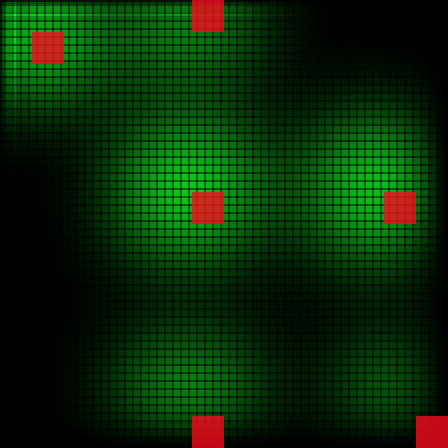

In [ ]:
# create a dummy input
inp = torch.ones((64,3,224,224), requires_grad=True)
m = model[:-1] # remove the last conv block

# run the forward pass
out = m(inp)

# hand-craft a new feature vector
grad = torch.zeros_like(out) # 14x14x256 features
grad[0, 0,  1,  1] = 1
grad[0, 0, 6,  12] = 1
grad[0, 0,  0,  6] = 1
grad[0, 0, 13,  6] = 1
grad[0, 0, 13, 13] = 1
grad[0, 0,  6,  6] = 1
grad.requires_grad_(True)

# calculate the input pixels that would change the feature vector the most
out.backward(gradient=grad)

# render the image
din = torch2img(grad[0,0], color=(250,10,30))
dout = torch2img(inp.grad[0,0], color=(10,250,30))
frame = Image.composite(din, dout, torch2img(grad[0,0], color=(200,)))
imageio.imwrite('14x14-receptive-fields.png', frame)
frame

We can also make a video showing the receptive field of every activation on the diagonal:

In [ ]:
images = []
for i in range(14):
    inp = torch.ones((64,3,224,224), requires_grad=True)
    m = model[:-1] # remove the last conv block

    # run the forward pass
    out = m(inp)

    # hand-craft a new feature vector
    grad = torch.zeros_like(out) # 14x14x256 features
    grad[0, 0,  i,  i] = 1
    grad.requires_grad_(True)

    # calculate the input pixels that would change the feature vector the most
    out.backward(gradient=grad)
    
    din = torch2img(grad[0,0], color=(250,10,30))
    dout = torch2img(inp.grad[0,0], color=(10,250,30), vmax=9.15) # force the same vmax for all frames
    frame = Image.composite(din, dout, torch2img(grad[0,0], color=(200,)))
    images.append(frame)

imageio.mimsave("14x14-receptive-fields.mp4", [frame for frame in images], fps=2)
from IPython.display import Video
Video("14x14-receptive-fields.mp4", embed=True)

## The surprising results

The red squares show the feature positions and the pixels affecting them are show in green.
224 (the input image size) / 14 (the feature map size) = 16 so you would expect each feature to cover an area of aproximately 16x16 pixels in the input.

In reality:
1. The receptive fields are much larger.
2. They are biased to both the left and top by about 8px.
3. The rightmost and bottom 8px are pretty much invisible to the network.
4. The 7th pixel row from the top is much more important than you would expect. This means the 2 topmost feature rows are calculating subtly different representations than the rest of the network for the same pixel content (no translation invariance).
5. The path to the last row and column of features is so suppressed that it has little chance to generate meaningful activations.

The first point is surprising but not difficult to explain: these features would have a 16x16 receptive field if all the convolutions were 1x1, otherwise it spreads out quite a bit with each layer.

My hyphotesis for 2. is that the strided convolutions are always calculated for the top left position in the 2x2 grid. After a few layers this adds up into a pretty big error.

I am not sure how to explain the 3rd, 4th and 5th effects.